**DHS in-country cross-validated model results.**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-Saved-Data" data-toc-modified-id="Load-Saved-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Saved Data</a></span><ul class="toc-item"><li><span><a href="#Load-labels,-locs,-and-years" data-toc-modified-id="Load-labels,-locs,-and-years-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load <code>labels</code>, <code>locs</code>, and <code>years</code></a></span></li><li><span><a href="#Load-loc_dict" data-toc-modified-id="Load-loc_dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load <code>loc_dict</code></a></span></li><li><span><a href="#Get-urban-v.-rural-indices" data-toc-modified-id="Get-urban-v.-rural-indices-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get urban v. rural indices</a></span></li><li><span><a href="#country_indices-and-country_labels" data-toc-modified-id="country_indices-and-country_labels-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span><code>country_indices</code> and <code>country_labels</code></a></span></li></ul></li><li><span><a href="#Load-saved-preds" data-toc-modified-id="Load-saved-preds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load saved preds</a></span><ul class="toc-item"><li><span><a href="#Create-CSV-of-all-preds" data-toc-modified-id="Create-CSV-of-all-preds-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create CSV of all preds</a></span></li></ul></li><li><span><a href="#Overall-MSE,-$R^2$,-$r^2$,-rank-corr" data-toc-modified-id="Overall-MSE,-$R^2$,-$r^2$,-rank-corr-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Overall MSE, $R^2$, $r^2$, rank-corr</a></span><ul class="toc-item"><li><span><a href="#Individual-model-results" data-toc-modified-id="Individual-model-results-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Individual model results</a></span></li><li><span><a href="#Model-Similarity-Heatmaps" data-toc-modified-id="Model-Similarity-Heatmaps-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Model Similarity Heatmaps</a></span></li><li><span><a href="#Cumulative-analysis" data-toc-modified-id="Cumulative-analysis-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Cumulative analysis</a></span></li></ul></li><li><span><a href="#Break-down-by-country,-urban/rural" data-toc-modified-id="Break-down-by-country,-urban/rural-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Break-down by country, urban/rural</a></span></li><li><span><a href="#$r^2$-over-all-countries" data-toc-modified-id="$r^2$-over-all-countries-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>$r^2$ over all countries</a></span></li><li><span><a href="#Break-down-by-country-year,-urban/rural" data-toc-modified-id="Break-down-by-country-year,-urban/rural-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Break-down by country-year, urban/rural</a></span></li><li><span><a href="#Urban/rural" data-toc-modified-id="Urban/rural-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Urban/rural</a></span><ul class="toc-item"><li><span><a href="#By-Country" data-toc-modified-id="By-Country-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>By Country</a></span></li></ul></li><li><span><a href="#Model-performance-as-function-of-NL" data-toc-modified-id="Model-performance-as-function-of-NL-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model performance as function of NL</a></span><ul class="toc-item"><li><span><a href="#When-NL-=-0" data-toc-modified-id="When-NL-=-0-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>When NL = 0</a></span></li><li><span><a href="#Predictions-vs.-NL-mean" data-toc-modified-id="Predictions-vs.-NL-mean-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Predictions vs. NL mean</a></span></li></ul></li></ul></div>

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import defaultdict
import itertools
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../')
from batchers import dataset_constants
from utils.analysis import (
    calc_score,
    chunk_vs_score,
    evaluate_df,
    plot_chunk_vs_score,
    plot_label_vs_score,
    plot_percdata_vs_score,
    sorted_scores)
from utils.general import colordisplay, load_npz
from utils.plot import scatter_preds, symmetric_heatmap

In [3]:
LOGS_ROOT_DIR = '../logs/'
DATASET_NAME = '2009-17'

MODEL_NAME_TO_DIR = {
    # KNN
    'KNN NL mean scalar': 'dhs_knn/incountry_nlmean_scalar',
    # 'KNN NL center scalar': 'dhs_knn/incountry_nlcenter_scalar',
    # 'KNN NL hist': 'dhs_knn/incountry_nl_hist',

    # GBT
    'GBT NL mean scalar': 'dhs_gbt/nls_mean',

    # Ridge
    'Ridge NL mean scalar': 'dhs_ridge/incountry_nlmean_scalar',
    # 'Ridge NL center scalar': 'dhs_ridge/incountry_nlcenter_scalar',
    'Ridge RGB hist': 'dhs_ridge/incountry_rgb_hist',
    'Ridge MS hist': 'dhs_ridge/incountry_ms_hist',
    'Ridge NL hist': 'dhs_ridge/incountry_nl_hist',
    'Ridge RGB+NL hist': 'dhs_ridge/incountry_rgbnl_hist',
    'Ridge MS+NL hist': 'dhs_ridge/incountry_msnl_hist',

    # Resnet
    'Resnet-18 MS': 'dhs_resnet/incountry_ms',
    'Resnet-18 MS+NL concat': 'dhs_resnet/incountry_msnl_concat',
    'Resnet-18 NL': 'dhs_resnet/incountry_nl',

    # Transfer
    'Resnet-18 RGB Transfer': 'dhs_resnet/incountry_rgb_transfer',
    'Resnet-18 MS Transfer': 'dhs_resnet/incountry_ms_transfer',
}

MODEL_NAMES = sorted(MODEL_NAME_TO_DIR.keys())

# Load Saved Data

## Load `labels`, `locs`, and `years`

In [4]:
npz = load_npz('../data/dhs_image_hists.npz')

labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

num_examples = len(labels)
assert np.all(np.asarray([len(labels), len(locs), len(years), len(nls_center), len(nls_mean)]) == num_examples)

image_hists: dtype=int64, shape=(19669, 8, 102)
labels: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
years: dtype=int32, shape=(19669,)
nls_center: dtype=float32, shape=(19669,)
nls_mean: dtype=float32, shape=(19669,)


## Load `loc_dict`

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': False,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    }, ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [5]:
loc_dict_path = '../data/dhs_loc_dict.pkl'
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

## Get urban v. rural indices

In [6]:
def get_urban_rural_indices(locs, loc_dict):
    '''
    Args
    - locs: np.array, shape [N, 2]
    - loc_dict: dict, (lat, lon) => dict

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 0:
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print(f'num urban: {len(urban_indices)}\t num rural: {len(rural_indices)}')
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

num urban: 6801	 num rural: 12868


## `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [7]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(num_examples, dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    country_indices[country].append(i)

for i, country in enumerate(dataset_constants.DHS_COUNTRIES):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

country_indices['overall'] = np.arange(num_examples)

# Load saved preds

In [8]:
preds = {}

for model_name, model_dir in MODEL_NAME_TO_DIR.items():
    print(model_name)
    npz_path = os.path.join(LOGS_ROOT_DIR, model_dir, 'test_preds.npz')
    preds[model_name] = load_npz(npz_path)['test_preds']

KNN NL mean scalar
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
GBT NL mean scalar
test_preds: dtype=float32, shape=(19669,)
labels: dtype=float32, shape=(19669,)
Ridge NL mean scalar
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Ridge RGB hist
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Ridge MS hist
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Ridge NL hist
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Ridge RGB+NL hist
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Ridge MS+NL hist
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Resnet-18 MS
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Resnet-18 MS+NL concat
labels: dtype=float32, shape=(19669,)
test_preds: dtype=float32, shape=(19669,)
Resnet-18 NL
test_preds: dt

## Create CSV of all preds

In [9]:
preds_df = pd.DataFrame(
    columns=['lat', 'lon', 'country', 'year', 'urban', 'label'] + MODEL_NAMES)
preds_df['lat'] = locs[:, 0]
preds_df['lon'] = locs[:, 1]
preds_df['label'] = labels
preds_df['year'] = years
preds_df['country'] = np.asarray(dataset_constants.DHS_COUNTRIES)[country_labels]
preds_df.loc[:, 'urban'] = False
preds_df.loc[urban_indices, 'urban'] = True

for model_name in MODEL_NAMES:
    preds_df[model_name] = preds[model_name]

preds_df.to_csv('dhs_incountry_preds.csv', index=False)

In [10]:
with pd.option_context('display.max_rows', 8):
    display(preds_df)

,lat,lon,country,year,urban,label,GBT NL mean scalar,KNN NL mean scalar,Resnet-18 MS,Resnet-18 MS Transfer,Resnet-18 MS+NL concat,Resnet-18 NL,Resnet-18 RGB Transfer,Ridge MS hist,Ridge MS+NL hist,Ridge NL hist,Ridge NL mean scalar,Ridge RGB hist,Ridge RGB+NL hist
0,-11.915085,22.876839,angola,2011,False,-1.019361,0.066740,-0.019221,-0.390992,-0.291000,-0.323341,0.064499,0.100915,-0.200766,-0.162210,-0.057393,-0.152830,-0.382097,-0.230248
1,-11.886975,22.924997,angola,2011,False,-1.090052,0.066740,-0.051404,-0.156854,0.283504,-0.144833,-0.012302,0.414761,-0.377638,-0.275873,-0.127868,-0.155960,-0.406639,-0.313764
2,-9.498591,17.830034,angola,2011,False,-1.143002,-0.094288,-0.283389,-0.771230,-0.481369,-0.686935,-0.354895,-0.189910,-0.265012,-0.502758,-0.389024,-0.114492,-0.135516,-0.331629
3,-8.864000,13.240764,angola,2011,True,1.056769,1.435274,1.338239,1.561391,2.295933,1.941339,2.189639,1.530513,1.613870,1.004514,0.998139,6.863133,0.686252,1.052304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19665,-18.031948,31.095280,zimbabwe,2015,True,1.268232,1.072453,1.114076,1.118740,0.972364,1.147921,1.073565,0.662143,0.938228,1.210746,1.137815,0.363561,0.353672,1.170177
19666,-18.021593,31.084930,zimbabwe,2015,True,1.506693,1.225397,1.207792,1.307682,1.332089,1.314649,1.249776,1.092515,1.091166,1.283275,1.213139,0.461929,0.395241,1.226546
19667,-17.989489,31.033354,zimbabwe,2015,True,1.882921,1.072453,1.161264,1.106786,1.018770,1.101288,0.986111,0.435525,1.039269,1.262058,1.157109,0.234361,0.404338,1.217583
19668,-17.998350,31.042618,zimbabwe,2015,True,1.880099,1.072453,1.115566,1.462343,0.963112,1.467821,1.121304,0.866946,1.046131,1.252182,1.154653,0.346169,0.406369,1.204274


# Overall MSE, $R^2$, $r^2$, rank-corr

## Individual model results

In [11]:
overall_df = evaluate_df(preds_df, cols=MODEL_NAMES)
overall_df.sort_values(by='r2', ascending=False, inplace=True)
colordisplay(overall_df)

,r2,R2,mse,rank
Resnet-18 MS+NL concat,0.702735,0.701183,0.195135,0.806064
Resnet-18 NL,0.681499,0.681376,0.208069,0.769332
Resnet-18 MS,0.674217,0.671931,0.214237,0.785648
KNN NL mean scalar,0.665154,0.664942,0.218801,0.758589
Ridge RGB+NL hist,0.66175,0.661657,0.220946,0.769465
Ridge MS+NL hist,0.658617,0.658598,0.222944,0.772393
GBT NL mean scalar,0.654257,0.654073,0.225899,0.74466
Ridge NL hist,0.652962,0.652907,0.22666,0.756101
Resnet-18 MS Transfer,0.604989,0.604531,0.258251,0.724205
Resnet-18 RGB Transfer,0.592336,0.591405,0.266822,0.730032


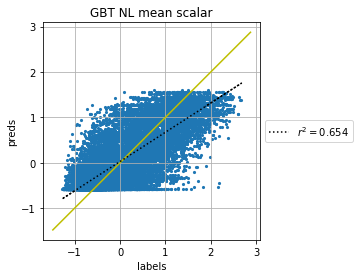

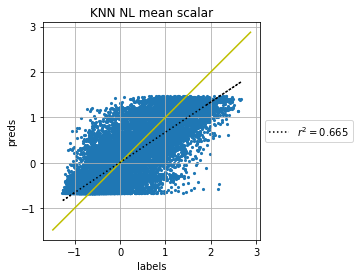

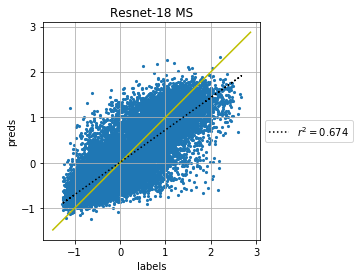

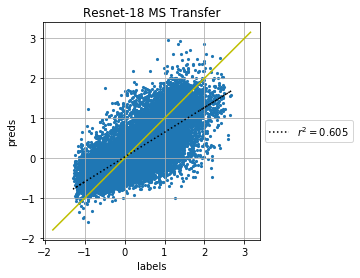

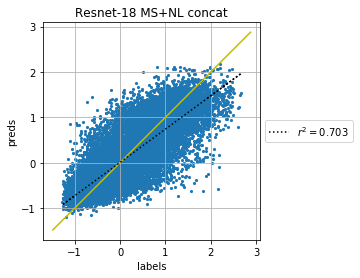

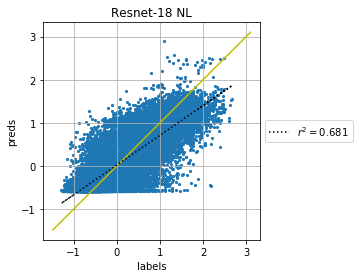

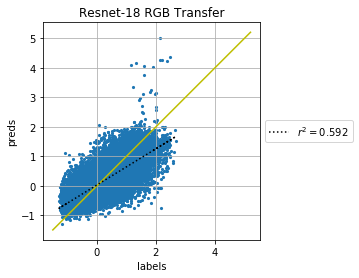

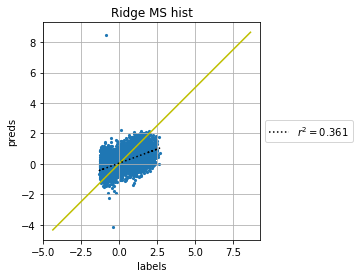

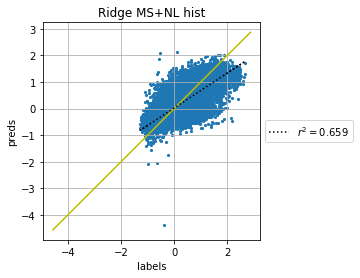

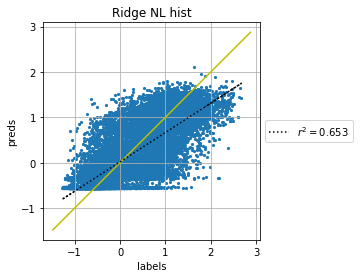

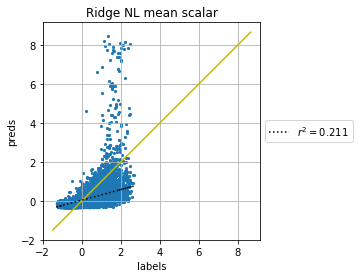

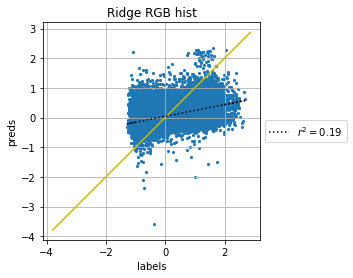

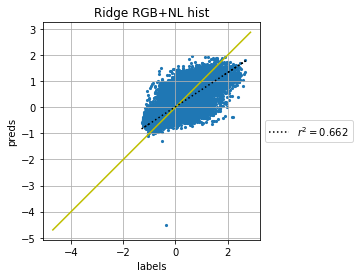

In [12]:
for model_name in MODEL_NAMES:
    model_preds = preds[model_name]
    scatter_preds(
        labels=labels,
        preds=model_preds,
        title=model_name,
        figsize=(4, 4))

## Model Similarity Heatmaps

In [13]:
model_names_by_mse = overall_df.sort_values(by='mse').index
num_models = len(preds)

r2_mat = np.eye(num_models, dtype=np.float64)
rank_mat = np.eye(num_models, dtype=np.float64)

for i, j in itertools.combinations(range(num_models), r=2):
    model_name1 = model_names_by_mse[i]
    model_name2 = model_names_by_mse[j]

    m1_preds = preds[model_name1]
    m2_preds = preds[model_name2]

    r2_mat[i, j] = calc_score(m1_preds, m2_preds, metric='r2')
    rank_mat[i, j] = calc_score(m1_preds, m2_preds, metric='rank')
    r2_mat[j, i] = r2_mat[i, j]
    rank_mat[j, i] = rank_mat[i, j]

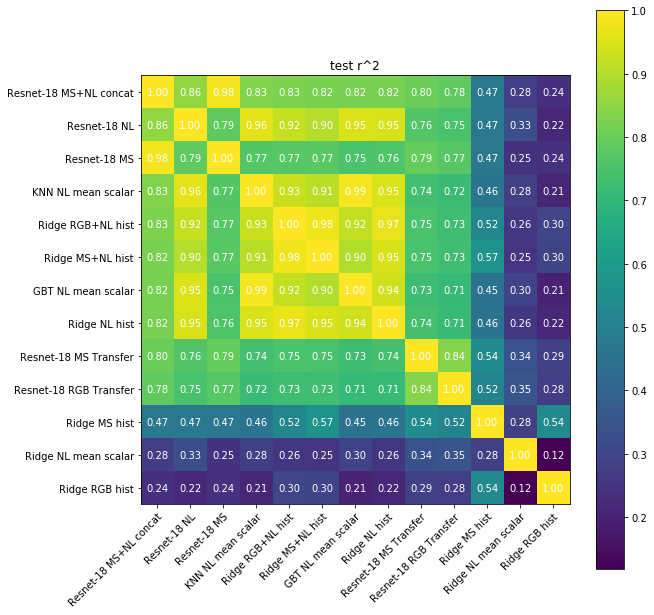

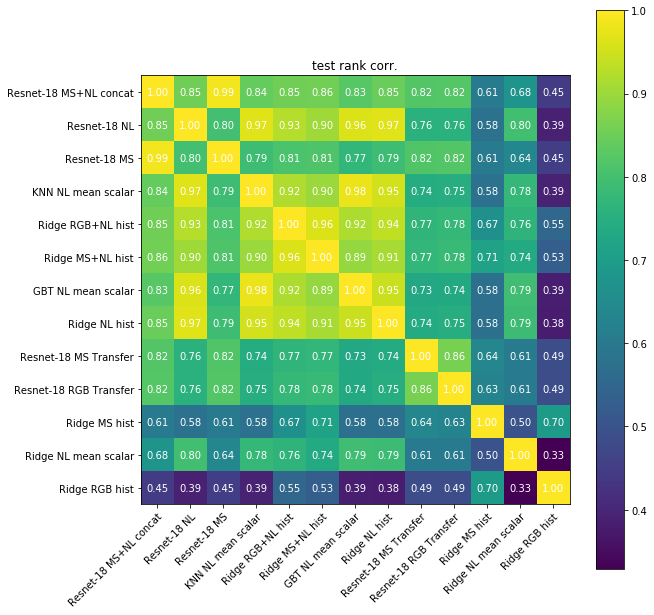

In [14]:
symmetric_heatmap(r2_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test r^2')
symmetric_heatmap(rank_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test rank corr.')

## Cumulative analysis

In [15]:
ridge_model_indices, ridge_model_names = [], []
resnet_model_indices, resnet_model_names = [], []

for i, model_name in enumerate(model_names_by_mse):
    if 'Resnet' not in model_name:
        ridge_model_indices.append(i)
        ridge_model_names.append(model_name)
    elif 'Resnet' in model_name:
        resnet_model_indices.append(i)
        resnet_model_names.append(model_name)

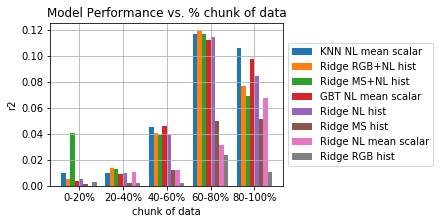

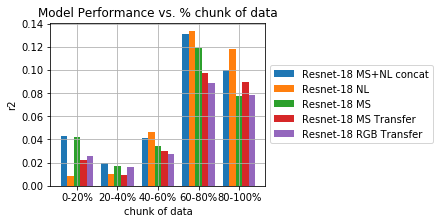

In [16]:
chunk_r2s = np.zeros([len(model_names_by_mse), 5])
for i, model_name in enumerate(model_names_by_mse):
    chunk_r2s[i, :] = chunk_vs_score(preds=preds[model_name], labels=labels, nchunks=5, metric='r2')

plot_chunk_vs_score(scores=chunk_r2s[ridge_model_indices], figsize=(6, 3),
                    legends=ridge_model_names, metric='r2')

plot_chunk_vs_score(scores=chunk_r2s[resnet_model_indices], figsize=(6, 3),
                    legends=resnet_model_names, metric='r2')

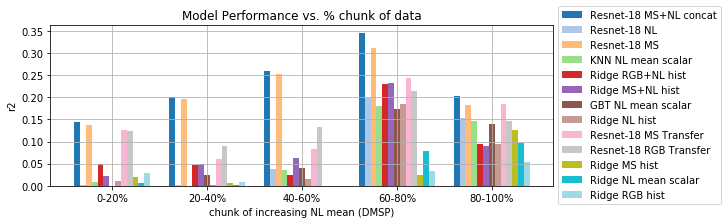

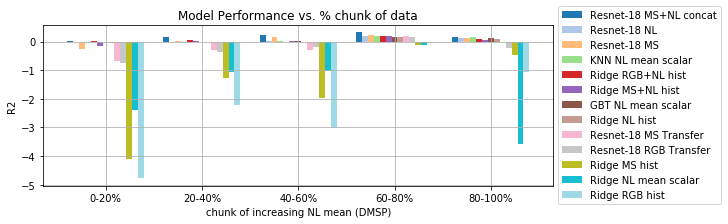

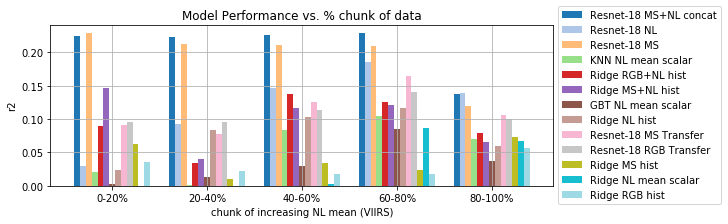

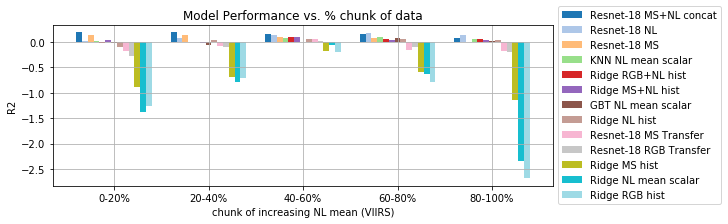

In [40]:
dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask

for name, mask in [('DMSP', dmsp_mask), ('VIIRS', viirs_mask)]:
    chunk_r2s = np.zeros([len(model_names_by_mse), 5])
    chunk_R2s = np.zeros([len(model_names_by_mse), 5])
    for i, model_name in enumerate(model_names_by_mse):
        chunk_r2s[i, :] = chunk_vs_score(labels=labels[mask], preds=preds[model_name][mask], nchunks=5,
                                         metric='r2', chunk_value=nls_mean[mask])
        chunk_R2s[i, :] = chunk_vs_score(labels=labels[mask], preds=preds[model_name][mask], nchunks=5,
                                         metric='R2', chunk_value=nls_mean[mask])

    plot_chunk_vs_score(scores=chunk_r2s, legends=overall_df.index, metric='r2',
                        figsize=(10, 3), cmap='tab20', xlabel=f'chunk of increasing NL mean ({name})')
    plot_chunk_vs_score(scores=chunk_R2s, legends=overall_df.index, metric='R2',
                        figsize=(10, 3), cmap='tab20', xlabel=f'chunk of increasing NL mean ({name})')

In [18]:
cumulative_r2s = np.zeros([len(model_names_by_mse), num_examples])

for i, model_name in enumerate(model_names_by_mse):
    r2s, labels_sorted = sorted_scores(
        preds=preds[model_name], labels=labels, metric='r2', sort='increasing')
    cumulative_r2s[i, :] = r2s

/atlas/u/chrisyeh/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


In [19]:
cumulative_r2_df = pd.DataFrame(
    data=cumulative_r2s.T,
    index=pd.Index(np.sort(labels), name='wealthpooled'),
    columns=model_names_by_mse)
with pd.option_context('display.max_rows', 4):
    display(cumulative_r2_df)

cumulative_r2_df.to_csv('dhs_incountry_cumulative_r2.csv', index=True)

,Resnet-18 MS+NL concat,Resnet-18 NL,Resnet-18 MS,KNN NL mean scalar,Ridge RGB+NL hist,Ridge MS+NL hist,GBT NL mean scalar,Ridge NL hist,Resnet-18 MS Transfer,Resnet-18 RGB Transfer,Ridge MS hist,Ridge NL mean scalar,Ridge RGB hist
wealthpooled,,,,,,,,,,,,,
-1.282605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1.269092,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.651037,0.702688,0.681432,0.674176,0.665097,0.661703,0.658584,0.654201,0.652896,0.604880,0.592233,0.360708,0.211276,0.189608
2.675832,0.702735,0.681499,0.674217,0.665153,0.661750,0.658617,0.654257,0.652962,0.604988,0.592336,0.360743,0.211494,0.189704


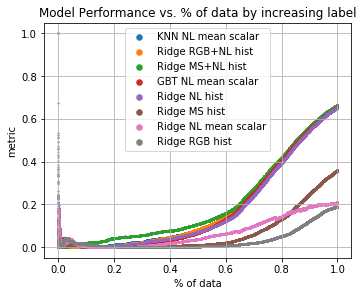

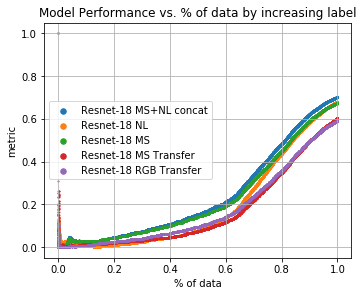

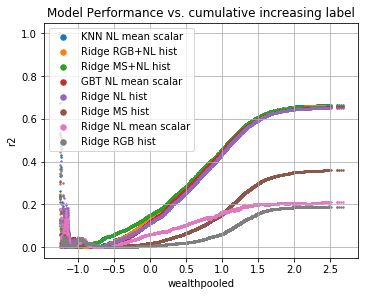

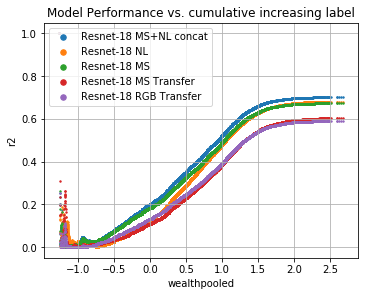

In [20]:
plot_percdata_vs_score(
    scores_list=cumulative_r2s[ridge_model_indices],
    legends=ridge_model_names,
    metric='r2',
    sort='increasing')

plot_percdata_vs_score(
    scores_list=cumulative_r2s[resnet_model_indices],
    legends=resnet_model_names,
    metric='r2',
    sort='increasing')

plot_label_vs_score(
    scores_list=cumulative_r2s[ridge_model_indices],
    labels_list=[np.sort(labels)] * len(ridge_model_indices),
    legends=ridge_model_names,
    metric='r2',
    sort='increasing')

plot_label_vs_score(
    scores_list=cumulative_r2s[resnet_model_indices],
    labels_list=[np.sort(labels)] * len(resnet_model_indices),
    legends=resnet_model_names,
    metric='r2',
    sort='increasing')

# Break-down by country, urban/rural

In [21]:
country_df = (
    preds_df
    .groupby('country')
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))
country_urban_df = (
    preds_df
    .groupby(['country', 'urban'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))

with pd.option_context('display.max_rows', 4, 'display.precision', 3):
    display(country_df)
    display(country_urban_df)

r2     R2    mse   rank
country  model                                         
angola   GBT NL mean scalar  0.747  0.667  0.398  0.845
         KNN NL mean scalar  0.745  0.692  0.368  0.842
...                            ...    ...    ...    ...
zimbabwe Ridge RGB hist      0.043 -0.258  1.067  0.190
         Ridge RGB+NL hist   0.728  0.530  0.399  0.820

[299 rows x 4 columns]

r2     R2    mse   rank
country  urban model                                             
angola   False GBT NL mean scalar  3.317e-01 -0.750  0.418  0.425
               KNN NL mean scalar  3.405e-01 -0.464  0.349  0.426
...                                      ...    ...    ...    ...
zimbabwe True  Ridge RGB hist      3.865e-06 -9.187  2.161 -0.019
               Ridge RGB+NL hist   1.870e-01 -2.188  0.676  0.444

[598 rows x 4 columns]

# $r^2$ over all countries

In [22]:
# get mean and median r^2 across countries
country_r2_df = country_df['r2'].unstack('model')
colordisplay(country_r2_df.describe().T)

print('urban:')
colordisplay(country_urban_df['r2'].unstack('model').loc[(slice(None), True), :].describe().T)

print('rural:')
colordisplay(country_urban_df['r2'].unstack('model').loc[(slice(None), False), :].describe().T)

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
GBT NL mean scalar,23,0.699175,0.0745024,0.542388,0.657315,0.682356,0.760993,0.821972
KNN NL mean scalar,23,0.699352,0.0746229,0.545323,0.657998,0.684811,0.756908,0.828163
Resnet-18 MS,23,0.669815,0.0765387,0.517349,0.621592,0.681204,0.727778,0.796281
Resnet-18 MS Transfer,23,0.607281,0.0899948,0.421658,0.558687,0.608174,0.677747,0.766037
Resnet-18 MS+NL concat,23,0.70064,0.0737319,0.566772,0.661906,0.707368,0.754629,0.814286
Resnet-18 NL,23,0.712831,0.0757558,0.557837,0.659451,0.713709,0.763388,0.836194
Resnet-18 RGB Transfer,23,0.599167,0.0861266,0.417263,0.554971,0.601346,0.651227,0.776856
Ridge MS hist,23,0.384914,0.151217,0.118719,0.258396,0.364161,0.514663,0.611687
Ridge MS+NL hist,23,0.668309,0.079535,0.512328,0.622625,0.682681,0.723825,0.785498


urban:


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
GBT NL mean scalar,23,0.43983,0.175219,0.0713487,0.336007,0.471035,0.56163,0.751034
KNN NL mean scalar,23,0.439462,0.174217,0.0781734,0.338875,0.472946,0.554877,0.734121
Resnet-18 MS,23,0.37276,0.167809,0.12157,0.228362,0.402638,0.49595,0.675809
Resnet-18 MS Transfer,23,0.355683,0.155621,0.0812174,0.277123,0.335773,0.452889,0.653081
Resnet-18 MS+NL concat,23,0.408362,0.172585,0.134878,0.296915,0.420714,0.530713,0.711656
Resnet-18 NL,23,0.452636,0.173467,0.105243,0.362632,0.496679,0.554014,0.771279
Resnet-18 RGB Transfer,23,0.347794,0.156478,0.0764655,0.247436,0.317577,0.449343,0.636896
Ridge MS hist,23,0.261765,0.148432,0.047112,0.144087,0.203216,0.363279,0.560634
Ridge MS+NL hist,23,0.414839,0.174761,0.0776529,0.299696,0.417965,0.556185,0.734187


rural:


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
GBT NL mean scalar,23,0.278966,0.125555,0.00460526,0.175784,0.297725,0.397875,0.440109
KNN NL mean scalar,23,0.278875,0.122385,0.0125048,0.187029,0.288622,0.395998,0.437062
Resnet-18 MS,23,0.25721,0.0929799,0.0572349,0.183353,0.253179,0.333811,0.418172
Resnet-18 MS Transfer,23,0.157005,0.0960313,0.026731,0.0887724,0.130119,0.226904,0.339936
Resnet-18 MS+NL concat,23,0.295384,0.0995948,0.0630482,0.227691,0.269238,0.373413,0.466147
Resnet-18 NL,23,0.287228,0.124627,0.0305166,0.18417,0.296862,0.396414,0.458314
Resnet-18 RGB Transfer,23,0.16801,0.0798553,0.0288652,0.111798,0.178364,0.216784,0.291877
Ridge MS hist,23,0.0616535,0.0501438,2.61845e-05,0.020017,0.0573112,0.0838197,0.157668
Ridge MS+NL hist,23,0.262983,0.100501,0.0756946,0.180433,0.244607,0.339401,0.428435


,weighted r2,median r2,mean r2,overall r2
model,,,,
Resnet-18 NL,0.691544,0.713709,0.712831,0.681499
Resnet-18 MS+NL concat,0.678812,0.707368,0.70064,0.702735
KNN NL mean scalar,0.67677,0.684811,0.699352,0.665154
GBT NL mean scalar,0.676202,0.682356,0.699175,0.654257
Ridge NL hist,0.656456,0.681843,0.679415,0.652962
Ridge RGB+NL hist,0.649772,0.682089,0.675605,0.66175
Resnet-18 MS,0.647373,0.681204,0.669815,0.674217
Ridge MS+NL hist,0.642482,0.682681,0.668309,0.658617
Resnet-18 MS Transfer,0.583655,0.608174,0.607281,0.604989


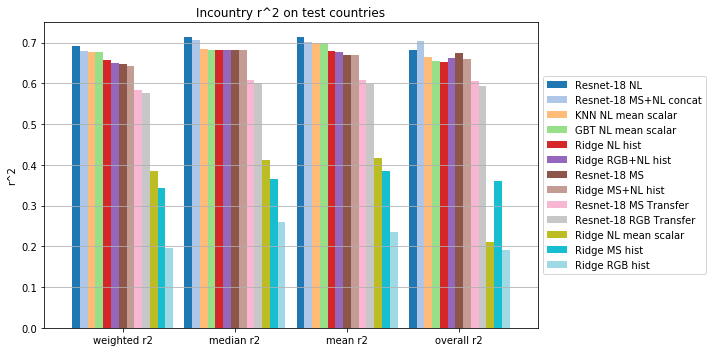

In [23]:
def weighted_r2(x):
    '''
    Args
    - x: pd.Series, index is (country, metric), value is score

    Returns:
    - y: float
    '''
    y = np.sum([
        x[country] * len(country_indices[country]) / len(labels)
        for country in x.index.get_level_values(0)
    ])
    return y

median_r2s = country_r2_df.median(axis=0).rename('median r2')
mean_r2s = country_r2_df.mean(axis=0).rename('mean r2')
weighted_r2s = country_r2_df.apply(weighted_r2, axis=0).rename('weighted r2')
overall_r2s = overall_df.loc[MODEL_NAMES, 'r2'].rename('overall r2')

agg_r2s = pd.concat([weighted_r2s, median_r2s, mean_r2s, overall_r2s], axis=1)
agg_r2s.sort_values(by='weighted r2', ascending=False, inplace=True)
colordisplay(agg_r2s)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
agg_r2s.T.plot(kind='bar', ax=ax, width=0.9, colormap='tab20')
plt.setp(ax.get_xticklabels(), rotation=0, ha='center',
         rotation_mode='anchor')
ax.set_ylabel('r^2')
ax.set_title('Incountry r^2 on test countries')
ax.grid(True, axis='y')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

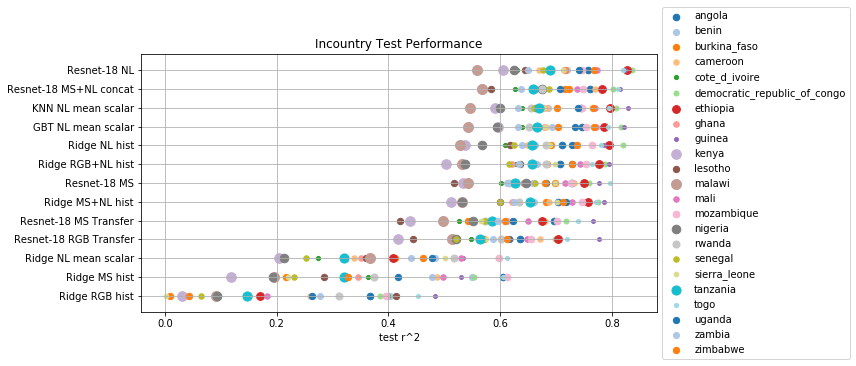

In [24]:
def plot_country_performance(df, model_names, title, xlabel):
    '''
    Args
    - df: pd.DataFrame, df.loc[country, model_name] gives model performance on a particular country
    - model_names: list of str
    - title: str
    - xlabel: str
    '''
    CMAP_FN = plt.cm.get_cmap('tab20')
    COUNTRY_YEAR_COLORS = [CMAP_FN.colors[i % 20] for i in range(len(dataset_constants.DHS_COUNTRIES))]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    for i, country in enumerate(dataset_constants.DHS_COUNTRIES):
        r2s = df.loc[country, model_names]
        size = len(country_indices[country]) / len(labels) * 1000
        ax.scatter(x=r2s, y=model_names, s=size, c=[COUNTRY_YEAR_COLORS[i]], label=country)

    ax.invert_yaxis()  # invert direction to put best-performing models at the top
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

plot_country_performance(
    df=country_r2_df,
    model_names=list(agg_r2s.index),
    title='Incountry Test Performance',
    xlabel='test r^2')

# Break-down by country-year, urban/rural

In [25]:
countryyear_df = (
    preds_df
    .groupby(['country', 'year'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))
countryyear_urban_df = (
    preds_df
    .groupby(['country', 'year', 'urban'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))

with pd.option_context('display.max_rows', 4, 'display.precision', 3):
    display(countryyear_df)
    display(countryyear_urban_df)

r2     R2    mse   rank
country  year model                                         
angola   2011 GBT NL mean scalar  0.778  0.712  0.399  0.829
              KNN NL mean scalar  0.776  0.722  0.385  0.817
...                                 ...    ...    ...    ...
zimbabwe 2015 Ridge RGB hist      0.026 -0.565  1.230  0.163
              Ridge RGB+NL hist   0.686  0.477  0.411  0.770

[559 rows x 4 columns]

r2      R2    mse   rank
country  year urban model                                          
angola   2011 False GBT NL mean scalar  0.264  -1.352  0.485  0.394
                    KNN NL mean scalar  0.277  -1.149  0.443  0.366
...                                       ...     ...    ...    ...
zimbabwe 2015 True  Ridge RGB hist      0.002 -12.945  2.691  0.062
                    Ridge RGB+NL hist   0.122  -2.644  0.703  0.353

[1118 rows x 4 columns]

In [26]:
# get mean and median r^2 across country_years
countryyear_r2_df = countryyear_df['r2'].unstack('model')
colordisplay(countryyear_r2_df.describe().T)

print('urban:')
colordisplay(countryyear_urban_df['r2'].unstack('model').loc[(slice(None), slice(None), True), :].describe().T)

print('rural:')
colordisplay(countryyear_urban_df['r2'].unstack('model').loc[(slice(None), slice(None), False), :].describe().T)

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
GBT NL mean scalar,43,0.690436,0.080836,0.485983,0.637041,0.693951,0.749624,0.821972
KNN NL mean scalar,43,0.690387,0.0816008,0.477332,0.638696,0.691996,0.75062,0.828163
Resnet-18 MS,43,0.659759,0.0785321,0.49369,0.611682,0.659677,0.710773,0.796281
Resnet-18 MS Transfer,43,0.60192,0.0906962,0.400975,0.555212,0.611294,0.663426,0.766037
Resnet-18 MS+NL concat,43,0.68981,0.0754674,0.509057,0.642613,0.687179,0.743878,0.814286
Resnet-18 NL,43,0.702148,0.0818614,0.480458,0.639464,0.707154,0.768462,0.838221
Resnet-18 RGB Transfer,43,0.592773,0.0884861,0.405036,0.532984,0.59975,0.670225,0.776856
Ridge MS hist,43,0.366776,0.15423,0.0666537,0.270434,0.3452,0.488902,0.699487
Ridge MS+NL hist,43,0.656022,0.0867883,0.454477,0.605516,0.674068,0.711071,0.785498


urban:


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
GBT NL mean scalar,43,0.413682,0.182149,0.027664,0.312776,0.420022,0.557848,0.751034
KNN NL mean scalar,43,0.415307,0.180161,0.0255472,0.321333,0.413566,0.55015,0.734121
Resnet-18 MS,43,0.361105,0.170845,0.0772626,0.214954,0.382437,0.50822,0.675809
Resnet-18 MS Transfer,43,0.350693,0.159953,0.0526367,0.229072,0.340402,0.46451,0.653081
Resnet-18 MS+NL concat,43,0.389188,0.177037,0.0843194,0.260712,0.408723,0.527239,0.711656
Resnet-18 NL,43,0.428813,0.181193,0.0438519,0.304073,0.447236,0.542058,0.771279
Resnet-18 RGB Transfer,43,0.345949,0.161845,0.0383729,0.247044,0.335805,0.453259,0.636896
Ridge MS hist,43,0.25372,0.154306,0.0207835,0.151248,0.216607,0.369493,0.560634
Ridge MS+NL hist,43,0.38581,0.184273,0.0435883,0.271804,0.378276,0.52703,0.734187


rural:


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
GBT NL mean scalar,43,0.28681,0.132422,0.00460526,0.170921,0.305219,0.375407,0.514826
KNN NL mean scalar,43,0.287065,0.132296,0.0125048,0.185357,0.298064,0.375584,0.515443
Resnet-18 MS,43,0.25157,0.111548,0.0572349,0.159628,0.23186,0.323601,0.5243
Resnet-18 MS Transfer,43,0.162169,0.106347,0.00695397,0.0708696,0.145272,0.248968,0.398509
Resnet-18 MS+NL concat,43,0.290595,0.117266,0.0630482,0.19377,0.298,0.362711,0.558231
Resnet-18 NL,43,0.293327,0.131079,0.0272287,0.207279,0.296862,0.396376,0.541399
Resnet-18 RGB Transfer,43,0.166592,0.0921438,0.0218979,0.0861427,0.170519,0.245941,0.385352
Ridge MS hist,43,0.056433,0.0536696,0.000200806,0.0102149,0.0406629,0.0949118,0.196292
Ridge MS+NL hist,43,0.258753,0.11837,0.0600212,0.172821,0.255679,0.349607,0.502584


# Urban/rural

In [27]:
urban_rural_df = (
    preds_df
    .groupby('urban')
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model')
    .unstack('urban'))

with pd.option_context('display.max_rows', 20, 'display.precision', 3):
    display(urban_rural_df)

r2            R2           mse          rank       
urban                   False  True   False  True   False  True   False  True 
model                                                                         
GBT NL mean scalar      0.316  0.383  0.268  0.313  0.175  0.322  0.452  0.597
KNN NL mean scalar      0.332  0.397  0.298  0.328  0.168  0.315  0.484  0.612
Resnet-18 MS            0.359  0.415  0.311  0.343  0.165  0.307  0.557  0.623
Resnet-18 MS Transfer   0.244  0.367  0.184  0.194  0.195  0.377  0.420  0.602
Resnet-18 MS+NL concat  0.402  0.447  0.374  0.401  0.150  0.281  0.588  0.645
Resnet-18 NL            0.345  0.426  0.314  0.378  0.164  0.291  0.496  0.637
Resnet-18 RGB Transfer  0.241  0.346  0.152  0.173  0.203  0.387  0.447  0.586
Ridge MS hist           0.075  0.246 -0.350 -0.273  0.323  0.596  0.256  0.512
Ridge MS+NL hist        0.362  0.401  0.310  0.291  0.165  0.332  0.531  0.615
Ridge NL hist           0.330  0.396  0.289  0.288  0.170  0.333  0.475  0.609
Ridge NL mean scalar    0.115  0.131 -0.267 -1.020  0.304  0.946  0.349  0.574
Ridge RGB hist          0.027  0.135 -0.580 -0.741  0.378  0.815  0.204  0.409
Ridge RGB+NL hist       0.355  0.408  0.310  0.303  0.165  0.326  0.515  0.619

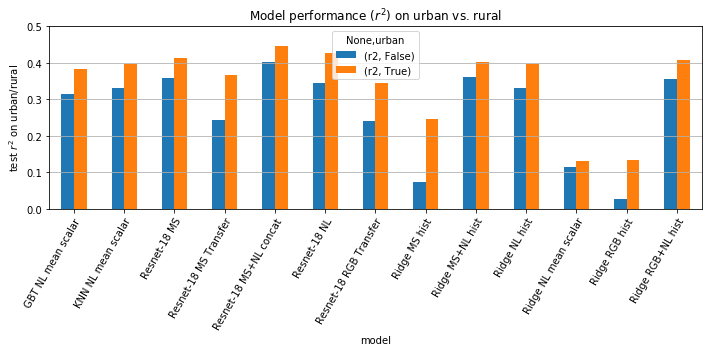

In [28]:
ax = urban_rural_df.loc[:, ('r2', slice(None))].plot(
    kind='bar', figsize=[10, 5])
ax.set_ylabel('test $r^2$ on urban/rural')
ax.set_ylim(bottom=0, top=0.5)
ax.set_title('Model performance ($r^2$) on urban vs. rural')
ax.grid(True, axis='y')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
         rotation_mode='anchor')
plt.tight_layout()
plt.show()

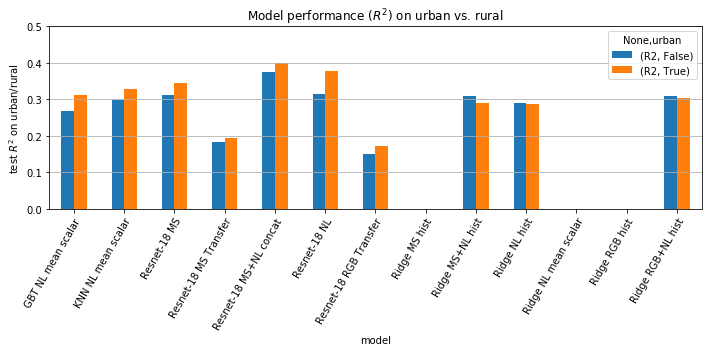

In [29]:
ax = urban_rural_df.loc[:, ('R2', slice(None))].plot(
    kind='bar', figsize=[10, 5])
ax.set_ylabel('test $R^2$ on urban/rural')
ax.set_ylim(bottom=0, top=0.5)
ax.set_title('Model performance ($R^2$) on urban vs. rural')
ax.grid(True, axis='y')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
         rotation_mode='anchor')
plt.tight_layout()
plt.show()

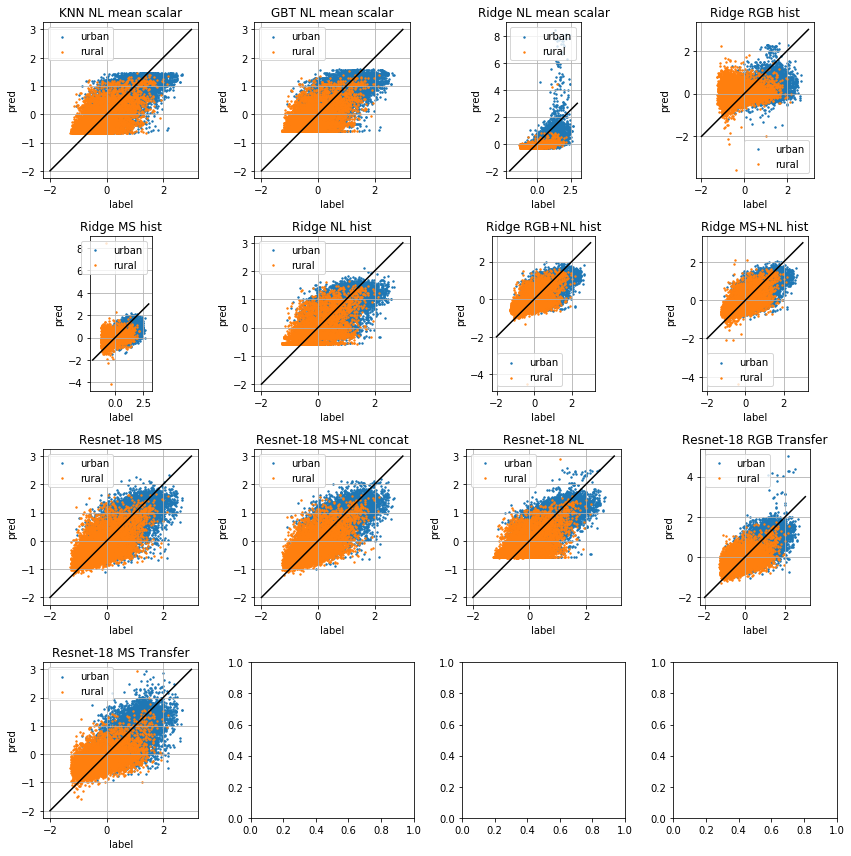

In [30]:
def plot_urban_rural_predictions(labels, preds, urban_indices, rural_indices):
    '''
    Args
    - labels: np.array, shape [N]
    - preds: dict, model_name => np.array, shape [N]
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    nrows = int(np.ceil(np.sqrt(len(preds))))
    ncols = int(np.ceil(len(preds) / nrows))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            sharey=False, sharex=False, figsize=[ncols*3, nrows*3])
    for model_name, ax in zip(preds, axs.flat):
        ax.scatter(
            x=labels[urban_indices],
            y=preds[model_name][urban_indices],
            s=2, label='urban')
        ax.scatter(
            x=labels[rural_indices],
            y=preds[model_name][rural_indices],
            s=2, label='rural')
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set(xlabel='label', ylabel='pred', title=model_name)
        xy_line = np.array([-2, 3])
        ax.plot(xy_line, xy_line, color='black')
        ax.legend()
    fig.tight_layout()
    plt.show()

plot_urban_rural_predictions(labels, preds, urban_indices, rural_indices)

## By Country

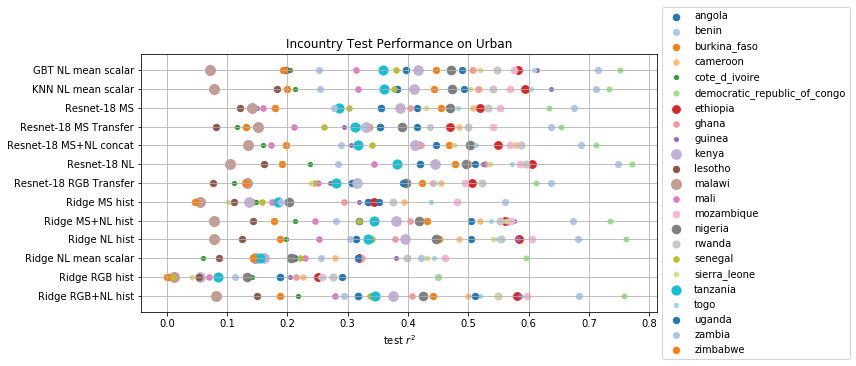

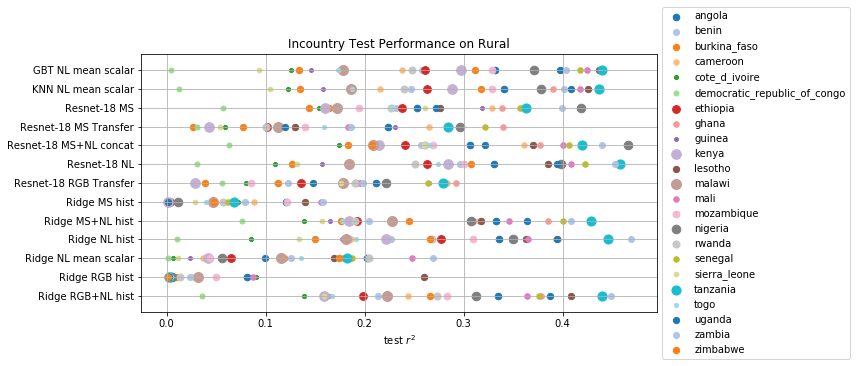

In [31]:
plot_country_performance(
    df=country_urban_df['r2'].unstack('model').loc[(slice(None), True), :],
    model_names=MODEL_NAMES,
    title='Incountry Test Performance on Urban',
    xlabel='test $r^2$')

plot_country_performance(
    df=country_urban_df['r2'].unstack('model').loc[(slice(None), False), :],
    model_names=MODEL_NAMES,
    title='Incountry Test Performance on Rural',
    xlabel='test $r^2$')

# Model performance as function of NL

## When NL = 0

In [32]:
from batchers.batcher import MEANS_DICT, STD_DEVS_DICT

dmsp0 = (0.0 - MEANS_DICT[DATASET_NAME]['DMSP']) / STD_DEVS_DICT[DATASET_NAME]['DMSP']
viirs0 = (0.0 - MEANS_DICT[DATASET_NAME]['VIIRS']) / STD_DEVS_DICT[DATASET_NAME]['VIIRS']

print('DMSP 0-value (after normalization):', dmsp0)
print('VIIRS 0-value (after normalization):', viirs0)

dmsp0_indices = (years < 2012) & (nls_mean == dmsp0)
viirs0_indices = (years >= 2012) & (nls_mean == viirs0)
nl0_indices = dmsp0_indices | viirs0_indices

assert np.all(nls_mean[nl0_indices] == dmsp0)
assert np.all(nls_center[nl0_indices] == dmsp0)

DMSP 0-value (after normalization): -0.17386247362598484
VIIRS 0-value (after normalization): -0.2290029111929456


In [33]:
print('# of locs w/ DMSP=0:', np.sum(dmsp0_indices))
print('# of locs w/ VIIRS=0:', np.sum(viirs0_indices))
print('# of locs w/ NL=0:', np.sum(nl0_indices))

# of locs w/ DMSP=0: 4012
# of locs w/ VIIRS=0: 0
# of locs w/ NL=0: 4012


Because we train a separate ridge regression model for each left-out test country, we get many different predictions for when NL = 0.

In [34]:
# np.unique(preds['Resnet-18 NL'][nl0_indices])

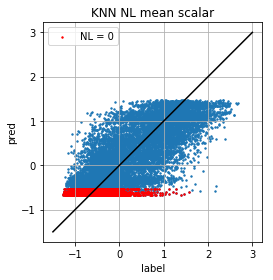

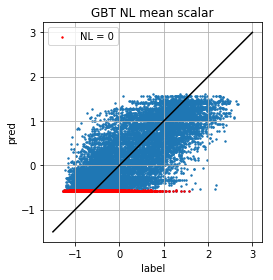

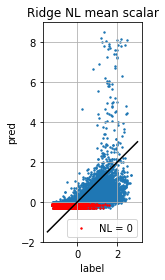

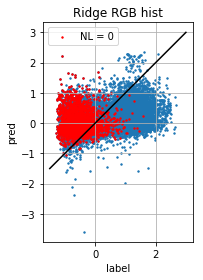

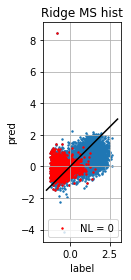

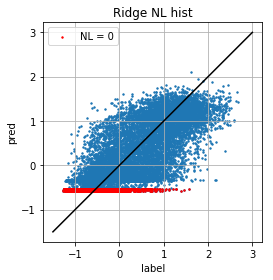

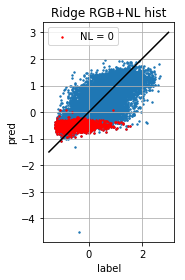

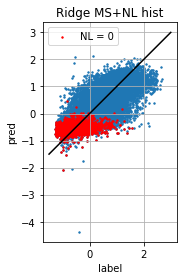

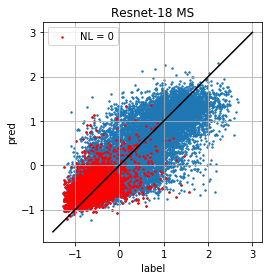

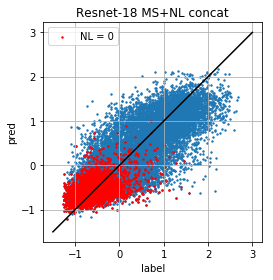

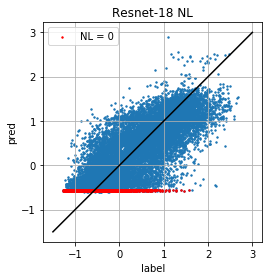

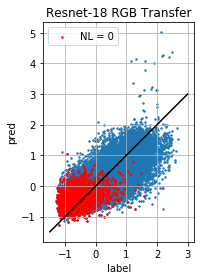

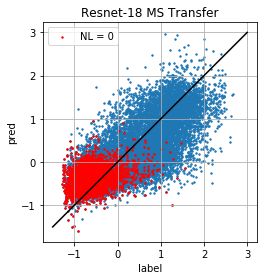

In [35]:
def plot_preds_nl0(model_name, labels, preds, nl0_indices):
    '''
    Args
    - model_name: str
    - labels: np.array, shape [num_examples]
    - preds: np.array, shape [num_examples]
    - nl0_indices: np.array, integer indices into labels/preds
    '''
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.scatter(x=labels, y=preds, s=2)
    ax.scatter(x=labels[nl0_indices], y=preds[nl0_indices], c='red', s=2, label='NL = 0')
    ax.set(xlabel='label', ylabel='pred', title=model_name)
    ax.grid(True)
    ax.set_aspect('equal')
    xy_line = np.array([-1.5, 3])
    ax.plot(xy_line, xy_line, color='black')
    ax.legend()
    fig.tight_layout()
    plt.show()

for model_name in MODEL_NAME_TO_DIR:
    plot_preds_nl0(model_name, labels, preds[model_name], nl0_indices)

In [36]:
nl0_df = evaluate_df(preds_df.loc[nl0_indices, :], cols=MODEL_NAMES)
nl0_df.sort_values('r2', ascending=False, inplace=True)
display(nl0_df.style.format('{:.3f}'))

,r2,R2,mse,rank
Resnet-18 MS+NL concat,0.206,0.158,0.099,0.402
Resnet-18 MS,0.199,0.012,0.117,0.405
Resnet-18 RGB Transfer,0.111,-0.390,0.164,0.312
Resnet-18 MS Transfer,0.081,-0.426,0.168,0.247
Ridge MS+NL hist,0.040,-0.033,0.122,0.187
Ridge RGB+NL hist,0.031,-0.005,0.119,0.169
Ridge RGB hist,0.005,-3.347,0.513,0.122
GBT NL mean scalar,0.004,-0.007,0.119,-0.213
Ridge NL hist,0.002,-0.022,0.121,-0.041
Ridge MS hist,0.002,-2.308,0.391,0.059


## Predictions vs. NL mean

In [37]:
def plot_preds_v_nl(model_name, preds, nl_means):
    '''
    Args
    - model_name: str
    - preds: np.array
    - nl_means: np.array
    '''
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    ax.scatter(x=nl_means, y=preds, s=3)
    ax.set_title(model_name)
    ax.set_xlabel('Mean NL of Image (std dev from mean)')
    ax.set_ylabel('Predicted Wealthpooled')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

def plot_residuals_v_nl(model_name, preds, labels, nl_means):
    '''
    Args
    - model_name: str
    - preds: np.array
    - labels: np.array
    - nl_means: np.array
    '''
    residuals = labels - preds
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    ax.scatter(x=nl_means, y=residuals, s=3)
    ax.set_title(model_name)
    ax.set_xlabel('Mean NL of Image (std dev from mean)')
    ax.set_ylabel('Residual (label - pred)')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

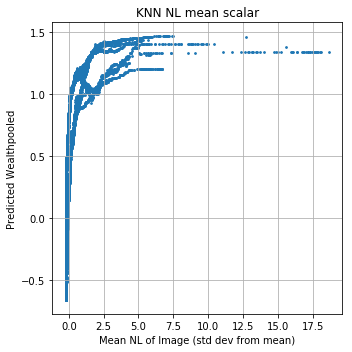

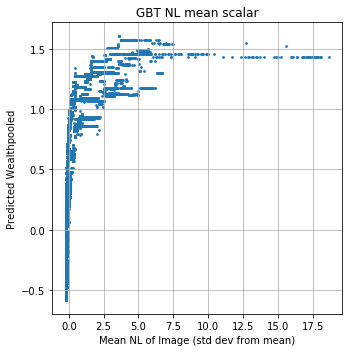

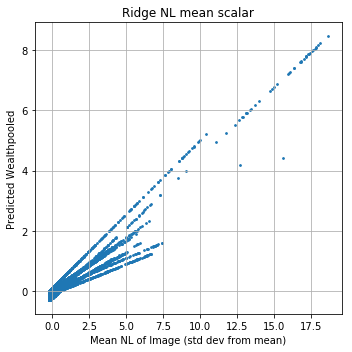

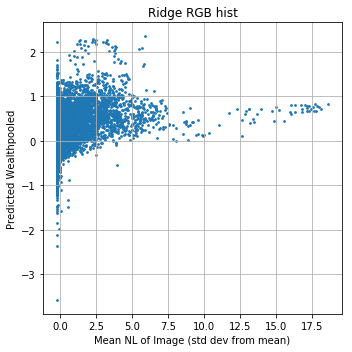

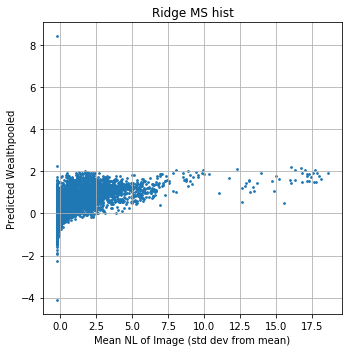

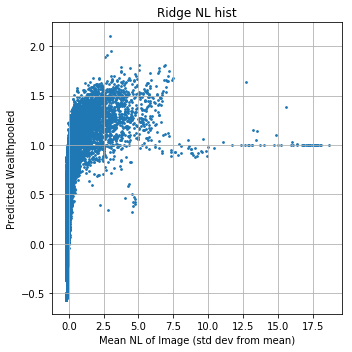

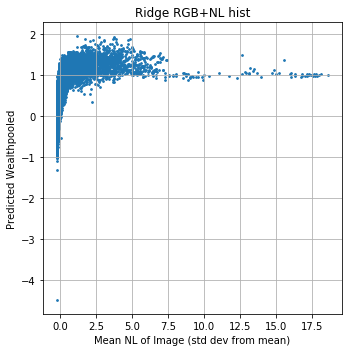

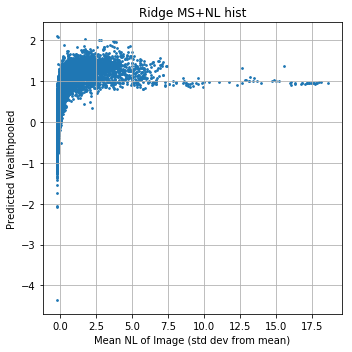

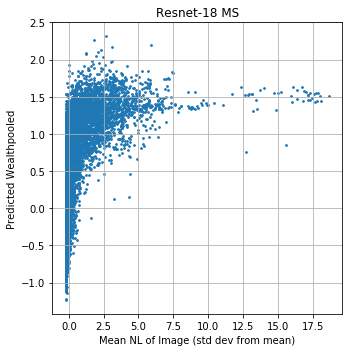

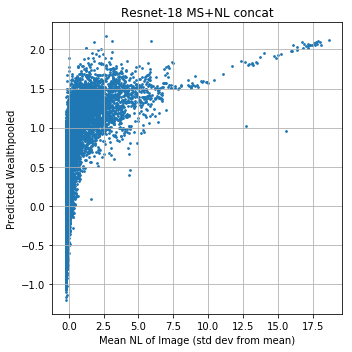

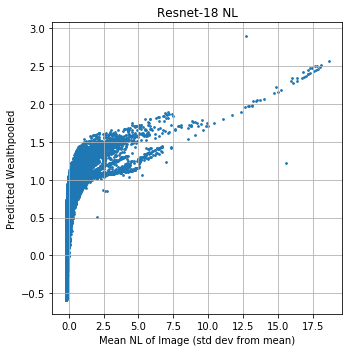

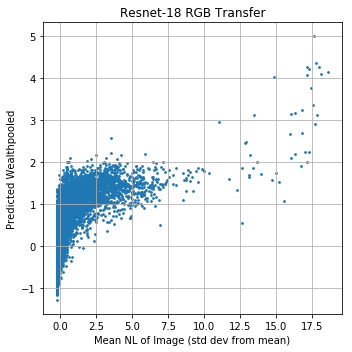

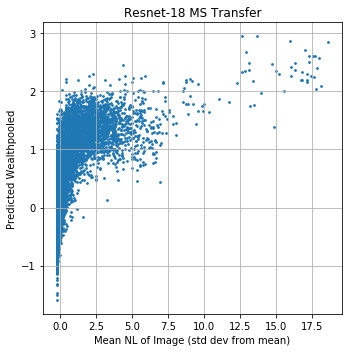

In [38]:
for model_name in MODEL_NAME_TO_DIR:
    plot_preds_v_nl(model_name, preds[model_name], nls_mean)

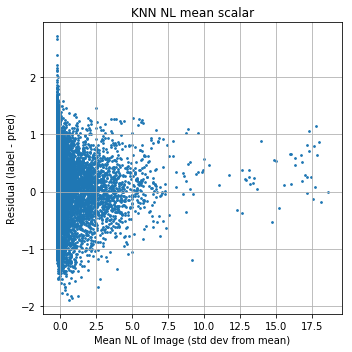

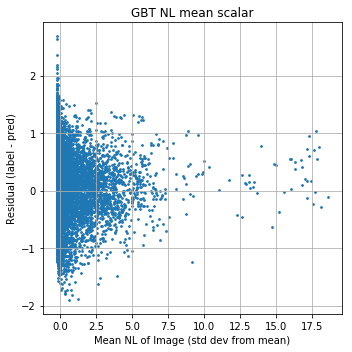

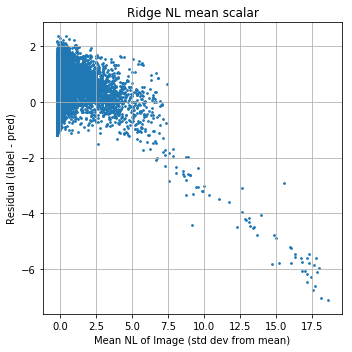

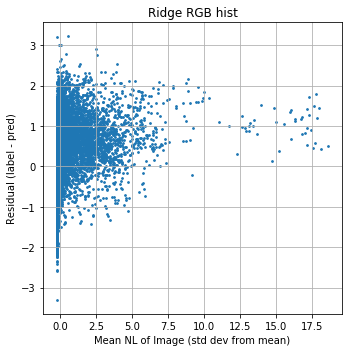

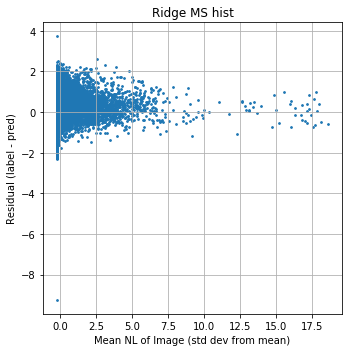

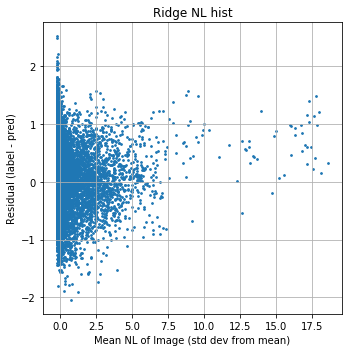

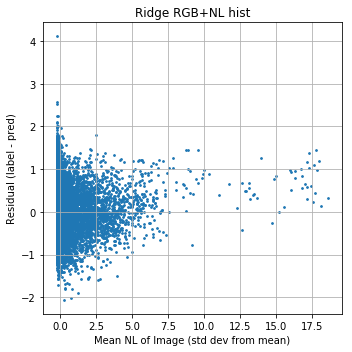

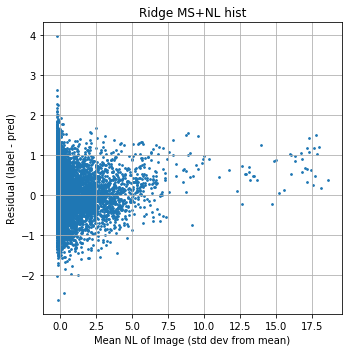

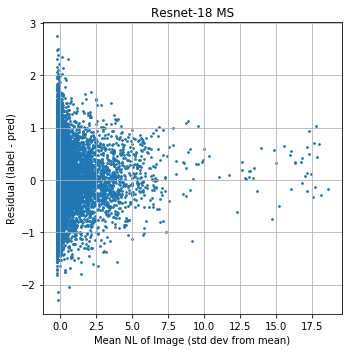

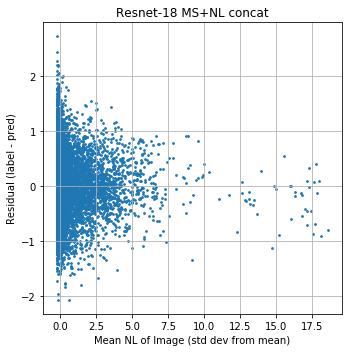

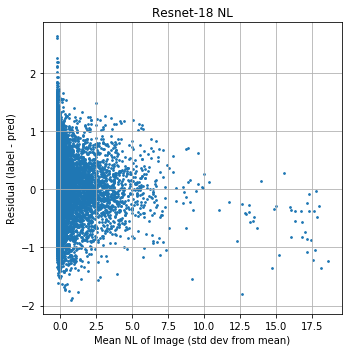

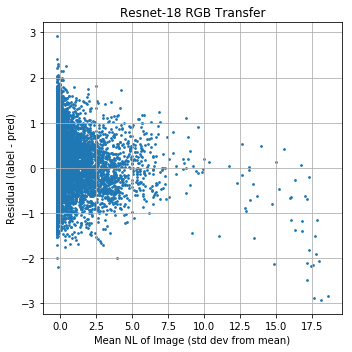

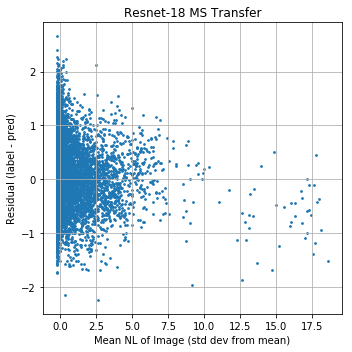

In [39]:
for model_name in MODEL_NAME_TO_DIR:
    plot_residuals_v_nl(model_name, preds[model_name], labels, nls_mean)